<a href="https://colab.research.google.com/github/mikulicmateo/StockPrediction/blob/main/MultioutputModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import json
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, BatchNormalization
from keras.layers.core import Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau
from matplotlib import pyplot
from datetime import datetime
import tensorflow as tf

In [2]:

def calculate_typical_price(row):
    typical_price = (row[1] + row[2] + row[3])/3
    return typical_price

In [3]:
with open("/content/drive/MyDrive/dataset-extendedv3.json") as json_file:
    dataset = json.loads(json_file.read())

In [4]:
num_given_days = 60
num_predicted_days = 30
data_per_day = 8

seq_len_x = num_given_days * data_per_day
seq_stride_x = num_predicted_days * data_per_day
seq_len_y = num_predicted_days
seq_stride_y = num_given_days

In [5]:
def make_y(data):
  new_data = []
  for i in range(len(data)):
    if i % data_per_day != 0:
      continue
    new_data.append(calculate_typical_price(data[i:i+data_per_day]))
  return new_data

In [6]:
ds_train_x = None
ds_train_y = None

ds_valid_x = None
ds_valid_y = None

ds_test_x = None
ds_test_y = None

def load_from_d(dataset):
  global ds_train_x
  global ds_train_y
  global ds_valid_x
  global ds_valid_y
  global ds_test_x   
  global ds_test_y   
  for j in dataset.keys():
    data_train = []
    data_valid = []
    data_test = []
    for i in dataset[j]:
      date_string = i.get('date')
      if date_string < "2018-01-01":
          data_train = data_train + ([float(i.get('open')), float(i.get('high')), float(i.get('low')), float(i.get('close')), \
              float(i.get('volume')), float(i.get('rsi')), float(i.get('sma')), float(i.get('ema'))])
      elif date_string < "2020-01-01":
          data_valid = data_valid + ([float(i.get('open')), float(i.get('high')), float(i.get('low')), float(i.get('close')), \
              float(i.get('volume')), float(i.get('rsi')), float(i.get('sma')), float(i.get('ema'))])
      else:
          data_test = data_test + ([float(i.get('open')), float(i.get('high')), float(i.get('low')), float(i.get('close')), \
              float(i.get('volume')), float(i.get('rsi')), float(i.get('sma')), float(i.get('ema'))])

    if len(data_train) >= seq_len_x:
      
      target_train = make_y(data_train)

      x_train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
          data_train,
          None,
          sequence_length=seq_len_x,
          sequence_stride=seq_stride_x,
          sampling_rate=1,
          batch_size=None,
          end_index=len(data_train)-seq_stride_x
      )

      y_train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
          target_train,
          None,
          sequence_length=seq_len_y,
          sequence_stride=seq_stride_y,
          sampling_rate=1,
          batch_size=None,
          start_index=num_given_days,
      )

    if len(data_valid) >= seq_len_x:

      target_valid = make_y(data_valid)
      x_valid_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
          data_valid,
          None,
          sequence_length=seq_len_x,
          sequence_stride=seq_stride_x,
          sampling_rate=1,
          batch_size=None,
          end_index=len(data_valid)-seq_stride_x
      )

      y_valid_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
          target_valid,
          None,
          sequence_length=seq_len_y,
          sequence_stride=seq_stride_y,
          sampling_rate=1,
          batch_size=None,
          start_index=num_given_days,
      )

    if len(data_test) >= seq_len_x:

      target_test = make_y(data_test)
      x_test_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
          data_test,
          None,
          sequence_length=seq_len_x,
          sequence_stride=seq_stride_x,
          sampling_rate=1,
          batch_size=None,
          end_index=len(data_test)-seq_stride_x
      )

      y_test_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
          data_test,
          None,
          sequence_length=seq_len_y,
          sequence_stride=seq_stride_y,
          sampling_rate=1,
          batch_size=None,
          start_index=num_given_days,
      )

    if not ds_train_x:
      ds_train_x = x_train_dataset
      ds_train_y = y_train_dataset
      ds_valid_x = x_valid_dataset
      ds_valid_y = y_valid_dataset
      ds_test_x = x_test_dataset
      ds_test_y = y_test_dataset
    else:
      ds_train_x = ds_train_x.concatenate(x_train_dataset)
      ds_train_y = ds_train_y.concatenate(y_train_dataset)
      ds_valid_x = ds_valid_x.concatenate(x_valid_dataset)
      ds_valid_y = ds_valid_y.concatenate(y_valid_dataset)
      ds_test_x = ds_test_x.concatenate(x_test_dataset)
      ds_test_y = ds_test_y.concatenate(y_test_dataset)

In [7]:
load_from_d(dataset)

In [8]:
def create_model():
  l_model = Sequential()
  l_model.add(Input(480))
#  l_model.add(Dense(960, activation="relu"))
#  l_model.add(Dense(480, activation="softplus"))
  l_model.add(Dense(240, activation="relu"))
  l_model.add(Dense(120, activation="softplus"))
#  l_model.add(Dropout(0.5))
  l_model.add(Dense(60, activation="linear"))
  l_model.add(Dense(30, activation="softplus"))
  l_model.compile(Adam(learning_rate=0.001), loss="msle", metrics=["mse", "mae", "msle"])
  return l_model

In [9]:
ds_train = tf.data.Dataset.zip((ds_train_x , ds_train_y)).batch(32)

In [10]:
ds_valid = tf.data.Dataset.zip((ds_valid_x, ds_valid_y)).batch(8)

In [11]:
for x,y in ds_valid:
  print(x.shape)
  print(y.shape)
  break

(8, 480)
(8, 30)


In [12]:
for x,y in ds_train:
  print(x.shape)
  print(y.shape)
  break

(32, 480)
(32, 30)


In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [14]:
model = create_model()
model.summary()
history = model.fit(ds_train, validation_data=ds_valid, epochs=30, verbose=1, shuffle=True, callbacks=[learning_rate_reduction])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 240)               115440    
                                                                 
 dense_1 (Dense)             (None, 120)               28920     
                                                                 
 dense_2 (Dense)             (None, 60)                7260      
                                                                 
 dense_3 (Dense)             (None, 30)                1830      
                                                                 
Total params: 153,450
Trainable params: 153,450
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
245/245 [==============================] - 19s 62ms/step - loss: 13.0346 - mse: 45198557184.0000 - mae: 9574.4033 - msle: 13.0346 - val_loss: 14.0981 - val_mse: 32680.0938

In [15]:
results = model.evaluate(ds_valid)
print(results)

111/111 [==============================] - 11s 23ms/step - loss: 14.0984 - mse: 32746.9863 - mae: 73.8279 - msle: 14.0984
[14.098374366760254, 32746.986328125, 73.82787322998047, 14.098374366760254]


In [23]:
ds_test_xx = ds_test_x.batch(8)
for x in ds_test_xx:
  print(x.shape)
  break

(8, 480)


In [24]:
predictions = model.predict(ds_test_xx)
print(predictions)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [58]:
ds_test_yy = ds_test_y.batch(8)

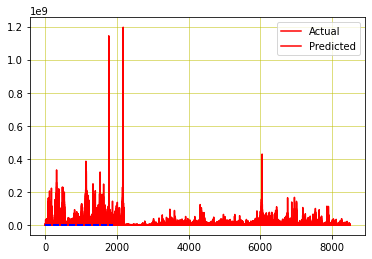

In [57]:
pyplot.plot(list(ds_test_y), linestyle='solid', color='r')
pyplot.plot(predictions, linestyle='dashed', color='b')
pyplot.legend(['Actual','Predicted'], loc='best')
pyplot.grid(color = 'y', linewidth='0.5')
pyplot.show()